In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.preprocessing import OrdinalEncoder,LabelEncoder 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Table Of Contents

1. Meeting our data

2. Visualization and data analysis

    2.1 Target variable and numerical data

    2.2 Categorical data

3. Data cleaning and Feature engineering

    3.1 Dealing with null values

    3.2 Label encoding

    3.3 Dealing with outliers 

4. Data normalization and one-hot encoding

5. Creating and evaluating a model

    5.1 Parameter tuning

    5.2 Models evaluations

    5.3 Model stacking

In [2]:
train=pd.read_csv('../input/spaceship-titanic/train.csv')
test=pd.read_csv('../input/spaceship-titanic/test.csv')

# set seed for reproducibility
np.random.seed(0)

# 1. Meeting Our Data!

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
#What is the number of rows and columns?

train.shape

(8693, 14)

In [5]:
#What data types do we have here?

train.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('bool')], dtype=object)

In [6]:
#Let's look at numeric data

train.select_dtypes(exclude = 'object').describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
#Let's look at categorical data

train.select_dtypes(include = 'object').describe()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [8]:
# Let's look at boolean data

target = train['Transported'].copy()
target.describe()

count     8693
unique       2
top       True
freq      4378
Name: Transported, dtype: object

# 2. Visualisation and EDA

In [9]:
# Setting up Seaborn library
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from scipy import stats

In [10]:
def plot_grid(data, fig_size, grid_size, plot_type, target = '',bins=10):
    """
    Custom function for plotting grid of plots.
    It takes: DataFrame of data, size of a grid, type of plots, string name of target variable;
    And it outputs: grid of plots.
    """
    fig = plt.figure(figsize = fig_size)
    if plot_type == 'histplot':
        for i, column_name in enumerate(data.select_dtypes(exclude = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            plot = sns.histplot(data[column_name], kde = True, color = 'red', stat = 'count', bins=bins)
            plot.set_xlabel(column_name, fontsize = 16)
            
    if plot_type == 'boxplot':
        for i, column_name in enumerate(data.select_dtypes(exclude = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            plot = sns.boxplot(x = data[column_name], color = 'red')
            plot.set_xlabel(column_name, fontsize = 16)
    if plot_type == 'scatterplot':
        for i, column_name in enumerate(data.drop(target, axis = 1).select_dtypes(exclude = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            plot = sns.scatterplot(x = data[column_name], y = data[target], color = 'red')
            plot.set_xlabel(column_name, fontsize = 16)
    if plot_type == 'boxplot_cat':
        for i, column_name in enumerate(data.select_dtypes(include = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            sort = data.groupby([column_name])[target].median().sort_values(ascending = False) # This is here to make sure boxes are sorted by median
            plot = sns.boxplot(x = data[column_name], y = data[target], order = sort.index, palette = 'Reds')
            plot.set_xlabel(column_name, fontsize = 16)
    plt.tight_layout()

# 2.1 Target variable and numerical data

In [11]:
# Let's look at the distribution of target variable

train['Transported'].value_counts().to_frame().style.background_gradient('Reds')

,Transported
True,4378
False,4315


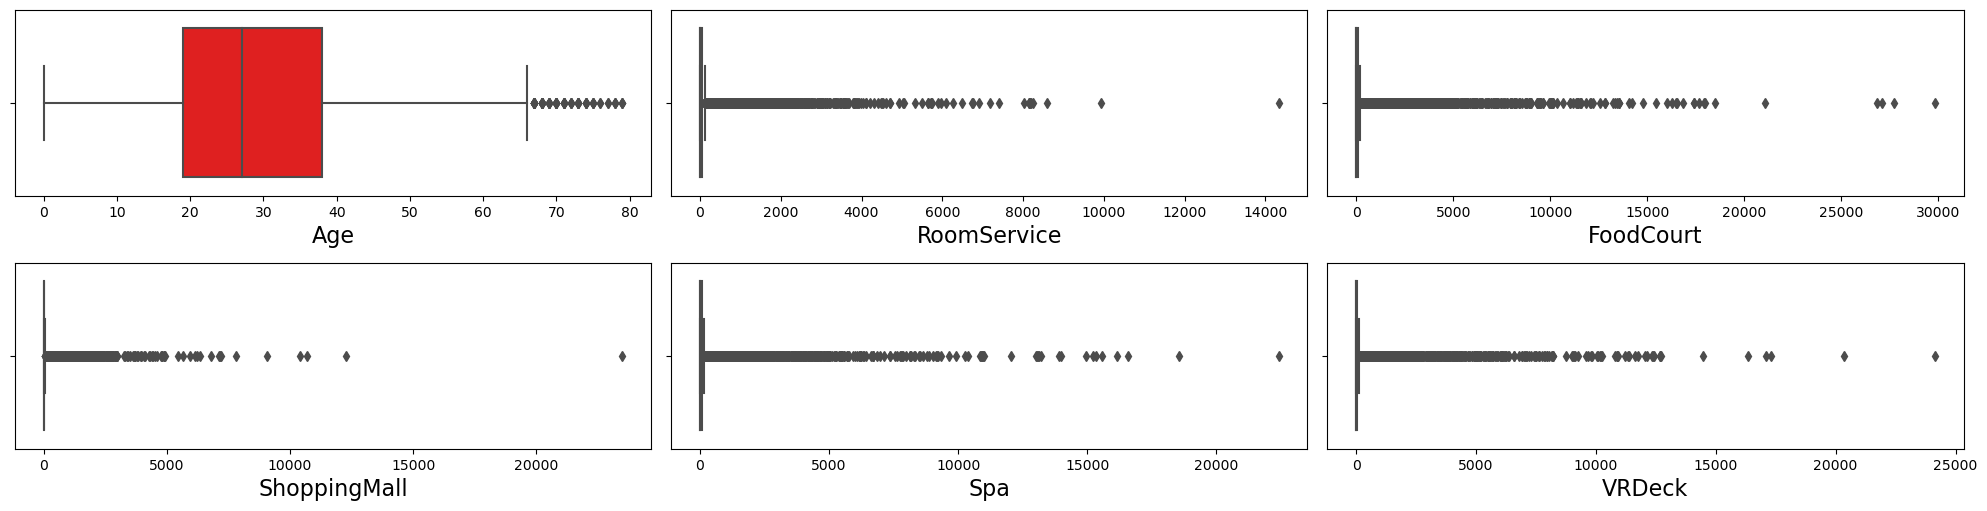

In [12]:
#Let's try some boxplot for our numerical features

plot_grid(train.drop('Transported',axis=1),
          fig_size=(20,30), grid_size=(12,3), plot_type='boxplot', target='Transported')

/tmp/ipykernel_32/1052083072.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train.corr()


<Axes: >

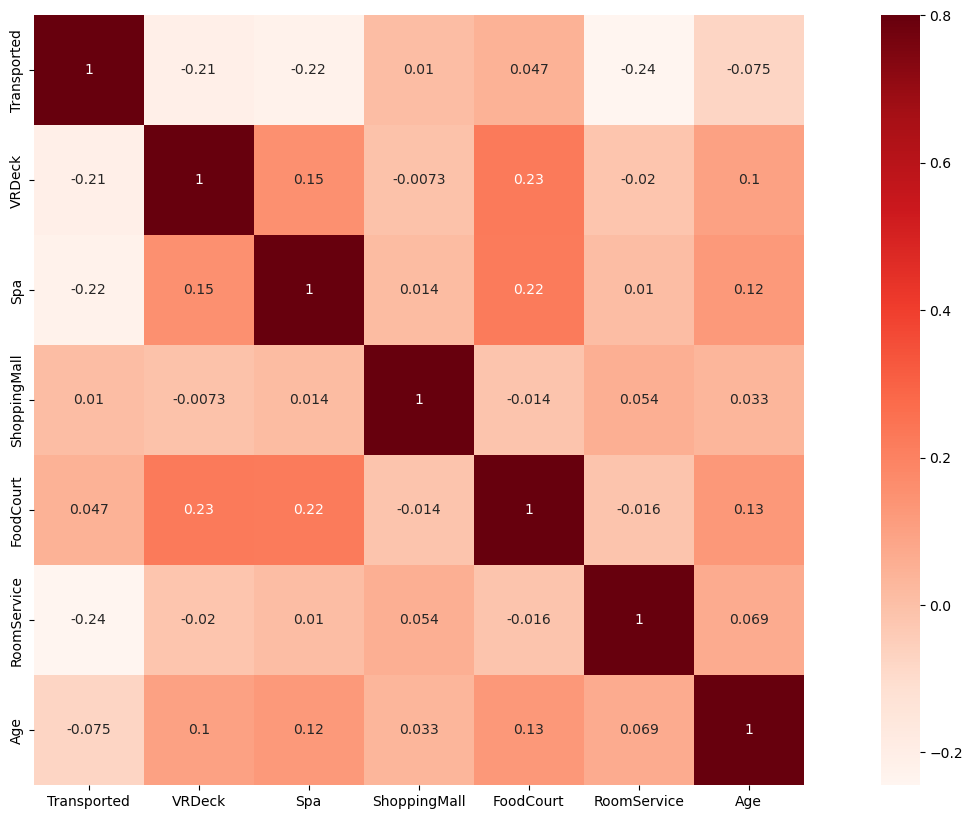

In [13]:
#Let's see the correlation matrix

correlation = train.corr()
plt.figure(figsize = (20,10))
sns.heatmap(correlation.loc[::-1,::-1], 
            square = True, 
            vmax = 0.8,
           cmap="Reds",
           annot=True)

Observation:

It looks like people who spent in Foodcourt, had some correlation with VRDeck and Spa too.

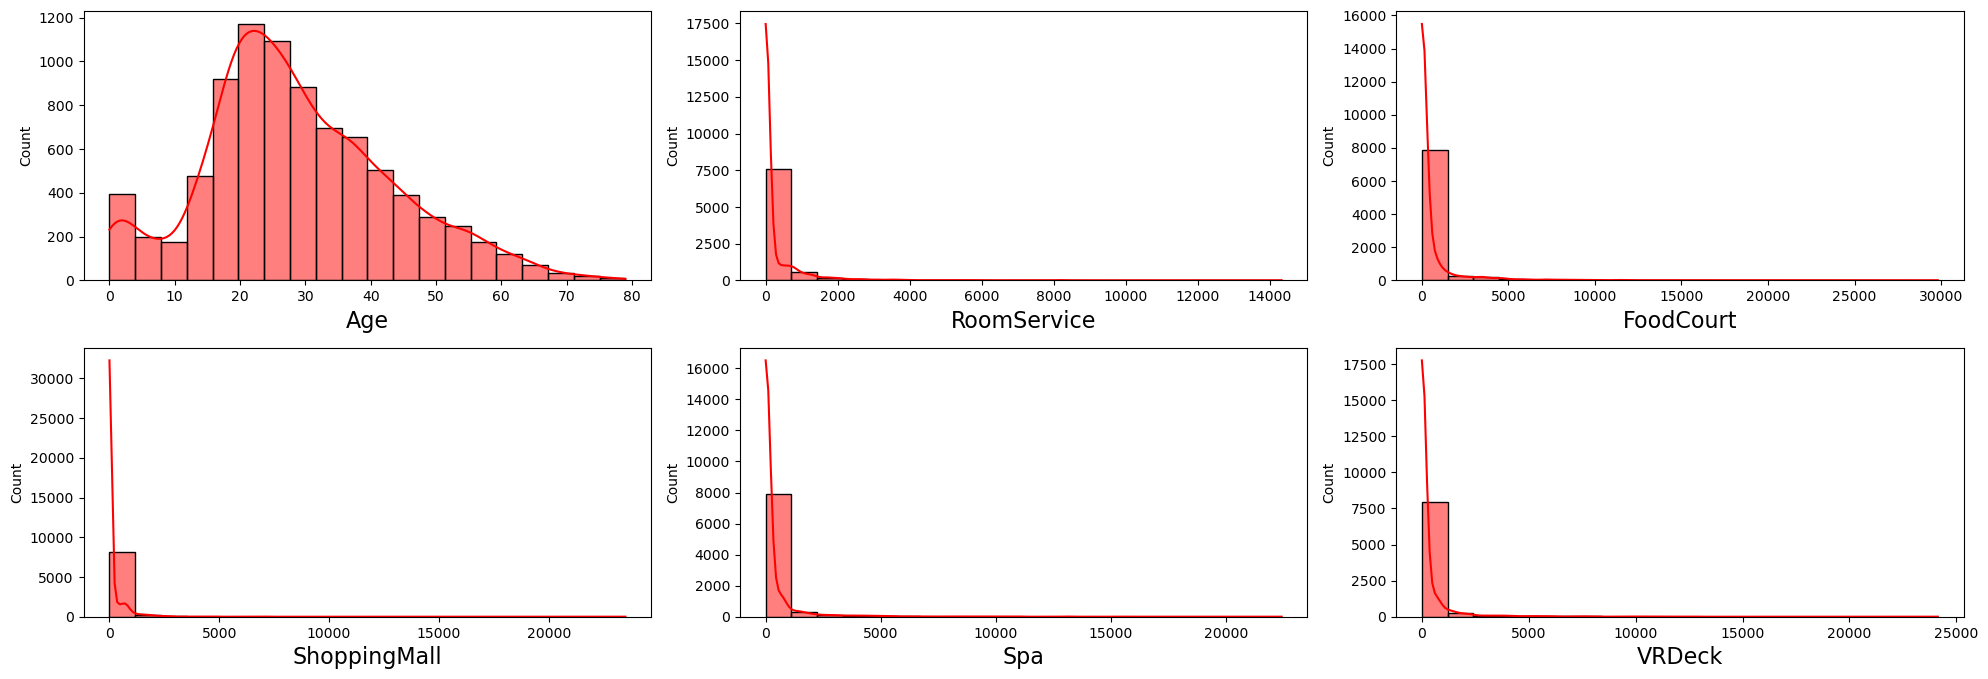

In [14]:
#Let's plot a histogram 

plot_grid(train.drop('Transported',axis=1),
          fig_size=(20,40), grid_size=(12,3), plot_type='histplot', bins=20)

Observations:

This numerical data could possibly lead to overfitting, so we might have to bucket them or normalise them at some point.

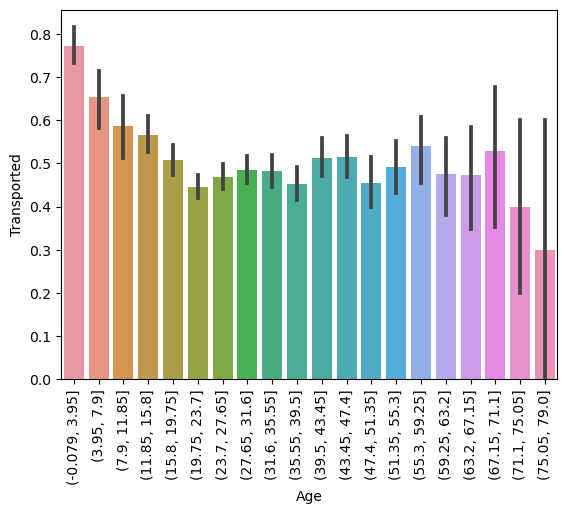

In [15]:
#How is Age correlated to Transported?
temp = train.copy()
temp=pd.cut(train['Age'],bins=20)
sns.barplot(data = train, x = temp, y = "Transported")

plt.xticks(rotation = 90)
plt.show()

Observation: 

Looks like Age does matter! We'll create some buckets to avoid overfitting.

# 2.2 Categorical Data Analysis

In [16]:
train.select_dtypes(include = 'object').nunique().sort_values(ascending = False)

PassengerId    8693
Name           8473
Cabin          6560
HomePlanet        3
Destination       3
CryoSleep         2
VIP               2
dtype: int64

<Axes: xlabel='VIP', ylabel='Transported'>

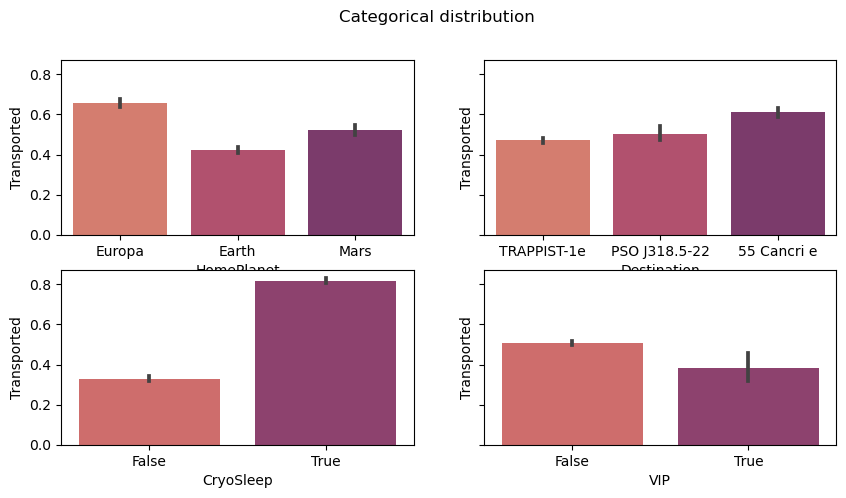

In [17]:
# Let's check the box plot for these
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(10,5))
fig.suptitle('Categorical distribution')

sns.barplot(ax=axes[0,0],data=train, x="HomePlanet", y="Transported",palette="flare")
sns.barplot(ax=axes[0,1],data=train, x="Destination", y="Transported",palette="flare")

sns.barplot(ax=axes[1,0],data=train, x="CryoSleep", y="Transported",palette="flare")
sns.barplot(ax=axes[1,1],data=train, x="VIP", y="Transported",palette="flare")


Observations:

1. Europa > Mars > Earth
2. There isn't much with destination. But Cancri e seems to be better
3. Those is cryosleep reached more.
4. Suprisingly, non-VIPs were transported more.

We can skip the high-cardinality columns like Name, Cabin and Passenger Id for now.
We can derive some important info from them through 

# 3. Data Cleaning and Feature Engineering

In [18]:
# Copy the train and test data before cleaning

train_cleaning = train.drop('Transported', axis = 1).copy()
test_cleaning = test.copy()

In [19]:
# Check for NULL values in numerical TRAIN data

null_cols_in_train=train_cleaning.select_dtypes(exclude="object").isnull().sum().sort_values(ascending = False)
percentage_in_train = null_cols_in_train.apply(lambda x: (x / train_cleaning.shape[0]) * 100)

missing_values = pd.concat([null_cols_in_train,percentage_in_train],
                            axis = 1, keys = ['Values missing', 'Percent of missing'])

missing_values[missing_values['Values missing'] > 0].style.background_gradient('Reds')

,Values missing,Percent of missing
ShoppingMall,208,2.392730
VRDeck,188,2.162660
FoodCourt,183,2.105142
Spa,183,2.105142
RoomService,181,2.082135
Age,179,2.059128


In [20]:
# Check for NULL values in numerical TEST data

null_cols_in_test=test_cleaning.select_dtypes(exclude="object").isnull().sum().sort_values(ascending = False)
percentage_in_test = null_cols_in_train.apply(lambda x: (x / test_cleaning.shape[0]) * 100)

missing_values = pd.concat([null_cols_in_test,percentage_in_test],
                            axis = 1, keys = ['Values missing', 'Percent of missing'])

missing_values[missing_values['Values missing'] > 0].style.background_gradient('Reds')

,Values missing,Percent of missing
FoodCourt,106,4.278700
Spa,101,4.278700
ShoppingMall,98,4.863222
Age,91,4.185177
RoomService,82,4.231938
VRDeck,80,4.395604


### Amenities

In [21]:
num_cols = ['FoodCourt','Spa','ShoppingMall','Age','RoomService','VRDeck']

train_cleaning[num_cols].head(10)

,FoodCourt,Spa,ShoppingMall,Age,RoomService,VRDeck
0,0.0,0.0,0.0,39.0,0.0,0.0
1,9.0,549.0,25.0,24.0,109.0,44.0
2,3576.0,6715.0,0.0,58.0,43.0,49.0
3,1283.0,3329.0,371.0,33.0,0.0,193.0
4,70.0,565.0,151.0,16.0,303.0,2.0
5,483.0,291.0,0.0,44.0,0.0,0.0
6,1539.0,0.0,3.0,26.0,42.0,0.0
7,0.0,0.0,0.0,28.0,0.0,NaN
8,785.0,216.0,17.0,35.0,0.0,0.0
9,0.0,0.0,0.0,14.0,0.0,0.0


In [22]:
#Most of the values above except Age means expenditure. 
#For NANs, we can substitute with median, since it is highly skewed

amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in amenities:
    train_cleaning[col].fillna(train_cleaning[col].median(), inplace=True)

In [23]:
train_cleaning['Total_Spent'] = train_cleaning.RoomService+train_cleaning.Spa
+train_cleaning.FoodCourt+train_cleaning.VRDeck+train_cleaning.ShoppingMall

0          0.0
1         78.0
2       3625.0
3       1847.0
4        223.0
         ...  
8688    6893.0
8689       0.0
8690    1872.0
8691    4284.0
8692    4700.0
Length: 8693, dtype: float64

### Categorical Data

In [24]:
# Check for NULL values in categorical TRAIN data

null_cols_in_train=train_cleaning.select_dtypes(include="object").isnull().sum().sort_values(ascending = False)
percentage_in_train = null_cols_in_train.apply(lambda x: (x / train_cleaning.shape[0]) * 100)

missing_values = pd.concat([null_cols_in_train,percentage_in_train],
                            axis = 1, keys = ['Values missing', 'Percent of missing'])

missing_values[missing_values['Values missing'] > 0].style.background_gradient('Reds')

,Values missing,Percent of missing
CryoSleep,217,2.496261
VIP,203,2.335212
HomePlanet,201,2.312205
Name,200,2.300702
Cabin,199,2.289198
Destination,182,2.093639


### Cabin

We have NULL values here. We will not be filling up cabin data. Instead, we will split it up

In [25]:
#Let's start with Cabin. What are the unique values in cabin?

train_cleaning.Cabin.unique()

array(['B/0/P', 'F/0/S', 'A/0/S', ..., 'G/1499/S', 'G/1500/S', 'E/608/S'],
      dtype=object)

In [26]:
cabin_split = train_cleaning['Cabin'].apply(lambda x: x.split('/') if type(x) != float else ['-1', '-1', '-1']).to_list()
cabin_split = np.array(cabin_split)

train_cleaning['Cabin_deck'] = cabin_split[:, 0]
train_cleaning['Cabin_num'] = cabin_split[:, 1]
train_cleaning['Cabin_side'] = cabin_split[:, 2]
train_cleaning.drop(columns='Cabin', inplace=True)

train_cleaning['Cabin_num']=train_cleaning['Cabin_num'].astype(int)

In [27]:
train_cleaning['Cabin_num'].describe()

count    8693.000000
mean      586.601173
std       513.906241
min        -1.000000
25%       152.000000
50%       407.000000
75%       983.000000
max      1894.000000
Name: Cabin_num, dtype: float64

In [28]:
#We can bin cabins

#train_cleaning['Cabin_Groups'] = pd.cut(train_cleaning['Cabin_num'], [-2,100,200, 300, 400, 500, 800, 1000, 1200, 1500, 1800, 2000]).astype(str)

### PassengerID

In [29]:
# I think we might have some good info in Passenger ID, so before proceeding further, I want to split the data

train_cleaning['groupId']= train_cleaning.PassengerId.apply(lambda d: d.split('_')[0])
train_cleaning['subId'] = train_cleaning.PassengerId.apply(lambda d: d.split('_')[1])

In [30]:
#We can also get the info of how many people each person is travelling with

group = train_cleaning['groupId'].value_counts().to_dict()
train_cleaning['Group_size'] = train_cleaning['PassengerId'].apply(lambda x: group[x.split('_')[0]])

train_cleaning['Group_size']=train_cleaning['Group_size'].astype(object)

<Axes: xlabel='subId', ylabel='Transported'>

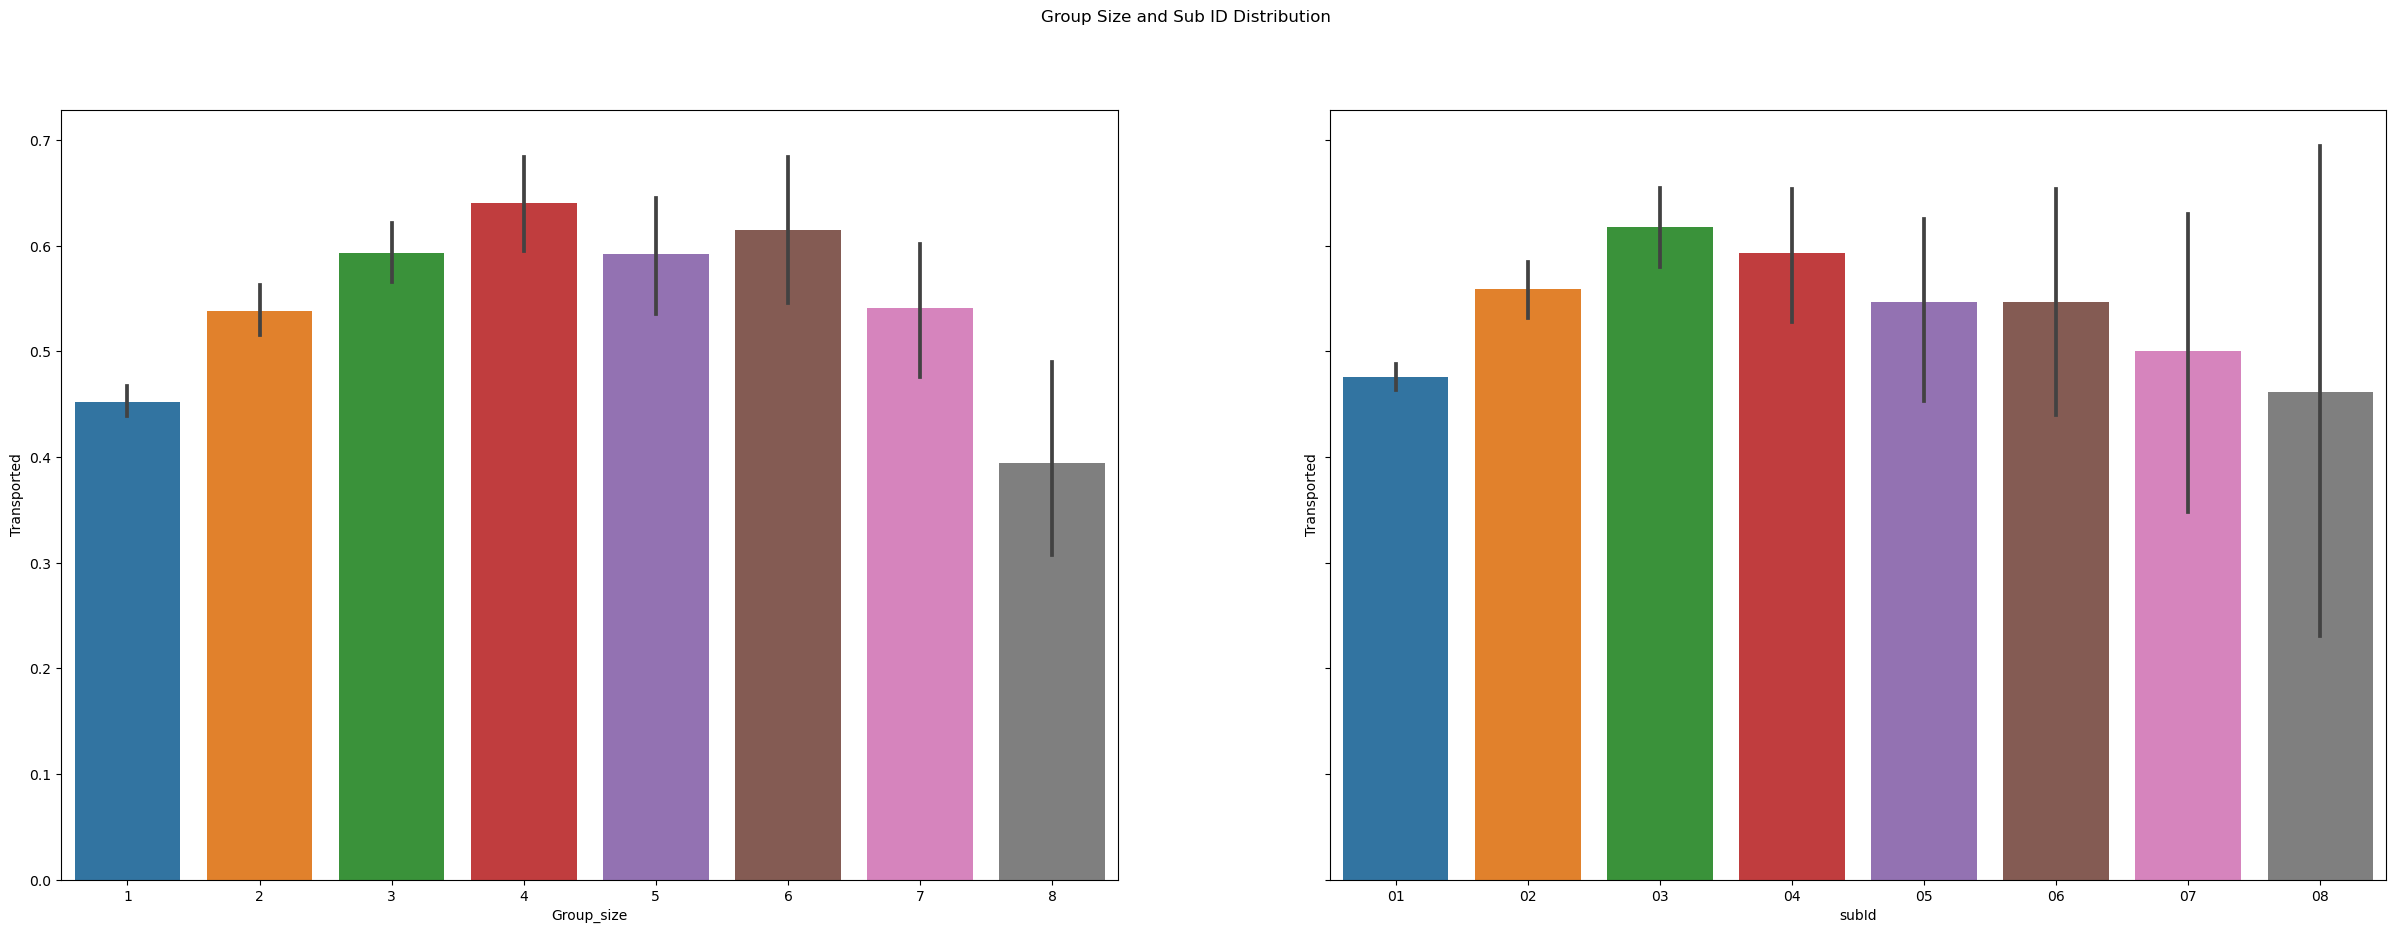

In [31]:
fig, axes = plt.subplots(1,2,sharey=True,figsize = (30,10))
fig.suptitle('Group Size and Sub ID Distribution')

sns.barplot(ax=axes[0],data=pd.concat([train_cleaning,target], axis=1),x='Group_size',y="Transported")
sns.barplot(ax=axes[1],data=pd.concat([train_cleaning,target], axis=1),x='subId',y="Transported")

### Name

In [32]:
#We can fill name with Unknown now

train_cleaning.Name.fillna('Unknown Unknown', inplace=True)

In [33]:
#Also, we can use the last name to split them into families
name_split = np.array(train_cleaning['Name'].apply(lambda x: x.split(' ') if type(x)==str else x).to_list())

train_cleaning['Name_first']= name_split[:,0]
train_cleaning['Name_last']= name_split[:,1]
train_cleaning.drop(columns='Name', inplace=True)

In [34]:
train_cleaning.Name_last.value_counts().nlargest(5)

Unknown      200
Casonston     18
Oneiles       16
Domington     15
Litthews      15
Name: Name_last, dtype: int64

### CryoSleep and VIP

In [35]:
train_cleaning[train_cleaning['Total_Spent']==0]['CryoSleep'].value_counts()

True     3037
False    1105
Name: CryoSleep, dtype: int64

In [36]:
# We have come to a conclusion that CryoSleep and VIP cannot be derived from data, 
# so we can assume that data not recorded can be recorded as False
# We assume the same for VIP also

train_cleaning.loc[:,'CryoSleep']=train_cleaning.CryoSleep.fillna(0).astype(int)
train_cleaning.loc[:,'VIP']=train_cleaning.VIP.fillna(0).astype(int)

/tmp/ipykernel_32/2611482580.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_cleaning.loc[:,'CryoSleep']=train_cleaning.CryoSleep.fillna(0).astype(int)
/tmp/ipykernel_32/2611482580.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_cleaning.loc[:,'VIP']=train_cleaning.VIP.fillna(0).astype(int)


### HomePlanet

In [37]:
# Let's look at the existing distribution of home planet

homeplanet = train_cleaning['HomePlanet'].value_counts()
print(homeplanet)

#Probability Distribution

pr_dis=homeplanet.values
pr_dis=pr_dis/sum(pr_dis)
print("\nProbability Distribution ",pr_dis)

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

Probability Distribution  [0.54192181 0.25094206 0.20713613]


In [38]:
#We can replace the NANs without disturbing the existing distribution. 

train_cleaning.loc[train_cleaning['HomePlanet'].isna(), 'HomePlanet'] = np.random.choice(homeplanet.index, train_cleaning['HomePlanet'].isna().sum(), p=pr_dis)

### Destination

We will use similar approach as above to assign values to Destination

In [39]:
# Let's look at the existing distribution of destination planet

destplanet = train_cleaning['Destination'].value_counts()
print(destplanet)

#Probability Distribution

dest_dis=destplanet.values
dest_dis=dest_dis/sum(dest_dis)
print("\nProbability Distribution ",dest_dis)

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

Probability Distribution  [0.69498296 0.21149101 0.09352603]


In [40]:
#We can replace the NANs without disturbing the existing distribution. 

train_cleaning.loc[train_cleaning['Destination'].isna(), 'Destination'] = np.random.choice(destplanet.index, train_cleaning['Destination'].isna().sum(), p=dest_dis)

### Age

We can fill Age also with uniform distrubution within one standard deviation of the mean age.
This way we can retain the overall distribution.

<Axes: xlabel='Age', ylabel='Count'>

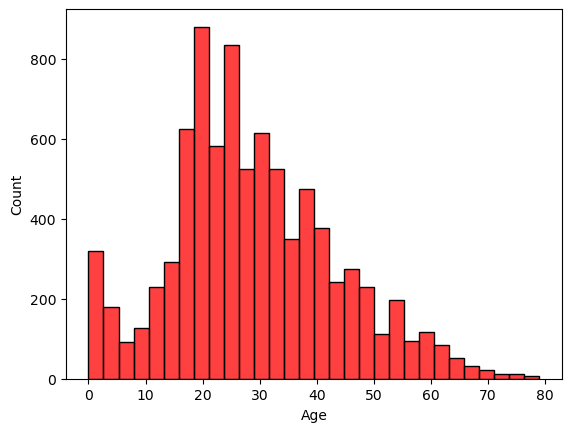

In [41]:
#Plot a histogram with bins

sns.histplot(train_cleaning['Age'], bins=30, kde=False, color="red")

In [42]:
mean_age = train_cleaning["Age"].mean()
std_age = train_cleaning["Age"].std()
is_null = train_cleaning["Age"].isnull().sum()

rand_sample = np.random.uniform(mean_age - std_age, mean_age + std_age, size = is_null)

train_cleaning.loc[train_cleaning['Age'].isna(), 'Age'] = rand_sample

In [43]:
#Now, that we've filled the NANs, we can bin them.

#train_cleaning['Age_Groups'] = pd.cut(train_cleaning['Age'], [0, 18, 45, 65, 100], include_lowest=True).astype(str)


In [44]:
train_cleaning.loc[train_cleaning['Age']==0]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_Spent,Cabin_deck,Cabin_num,Cabin_side,groupId,subId,Group_size,Name_first,Name_last
19,0017_01,Earth,0,TRAPPIST-1e,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,G,0,P,0017,01,2,Lyde,Brighttt
61,0067_01,Earth,1,PSO J318.5-22,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,G,10,S,0067,01,3,Ninaha,Leeves
86,0092_02,Earth,1,TRAPPIST-1e,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,G,9,P,0092,02,3,Stald,Hewson
102,0108_03,Earth,0,TRAPPIST-1e,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,G,19,S,0108,03,3,Oline,Handertiz
157,0179_02,Earth,0,TRAPPIST-1e,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,G,26,P,0179,02,3,Raque,Webstephrey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8494,9074_01,Earth,1,TRAPPIST-1e,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,G,1460,S,9074,01,6,Adamie,Trerady
8584,9163_01,Earth,1,TRAPPIST-1e,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,G,1477,S,9163,01,1,Idace,Edwartizman
8650,9227_04,Earth,1,TRAPPIST-1e,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,G,1498,P,9227,04,5,Robyny,Hinglendez
8654,9231_02,Mars,0,TRAPPIST-1e,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,F,1888,P,9231,02,3,Walls,Paie


In [45]:
#Double Check if There Is Any NULL values left!

train_cleaning.isnull().sum().max()

0

In [46]:
#Let's Repeat Everything for our Test Data

#Fill Amenities with Median Values
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in amenities:
    test_cleaning[col].fillna(test_cleaning[col].median(), inplace=True)

#Create New Feature Total Spent
test_cleaning['Total_Spent'] = test_cleaning.RoomService+test_cleaning.Spa
+test_cleaning.FoodCourt+test_cleaning.VRDeck+test_cleaning.ShoppingMall

#Get More Features From Cabin 
cabin_split = test_cleaning['Cabin'].apply(lambda x: x.split('/') if type(x) != float else ['-1', '-1', '-1']).to_list()
cabin_split = np.array(cabin_split)

test_cleaning['Cabin_deck'] = cabin_split[:, 0]
test_cleaning['Cabin_num'] = cabin_split[:, 1]
test_cleaning['Cabin_side'] = cabin_split[:, 2]
test_cleaning.drop(columns='Cabin', inplace=True)
test_cleaning['Cabin_num']=test_cleaning['Cabin_num'].astype(int)

#We can bin cabins
#test_cleaning['Cabin_Groups'] = pd.cut(test_cleaning['Cabin_num'], [-2,100,200, 300, 400, 500, 800, 1000, 1200, 1500, 1800, 2000]).astype(str)

# Sub Id of Passenger Id
test_cleaning['groupId'] = test_cleaning.PassengerId.apply(lambda d: d.split('_')[0])
test_cleaning['subId'] = test_cleaning.PassengerId.apply(lambda d: d.split('_')[1])

group = test_cleaning['groupId'].value_counts().to_dict()
test_cleaning['Group_size'] = test_cleaning['PassengerId'].apply(lambda x: group[x.split('_')[0]])
test_cleaning['Group_size']=test_cleaning['Group_size'].astype(object)

#Fill name with Unknown

test_cleaning.Name.fillna('Unknown Unknown', inplace=True)
name_split = np.array(test_cleaning['Name'].apply(lambda x: x.split(' ') if type(x)==str else x).to_list())

test_cleaning['Name_first']= name_split[:,0]
test_cleaning['Name_last']= name_split[:,1]
test_cleaning.drop(columns='Name', inplace=True)

#Fill Cryosleep and VIP with False/Zeroes

test_cleaning.loc[:,'CryoSleep']=test_cleaning.CryoSleep.fillna(0)
test_cleaning.loc[:,'VIP']=test_cleaning.VIP.fillna(0)

#Fill Home Planet

pr_dis=homeplanet.values
pr_dis=pr_dis/sum(pr_dis)
test_cleaning.loc[test_cleaning['HomePlanet'].isna(), 'HomePlanet'] = np.random.choice(homeplanet.index, test_cleaning['HomePlanet'].isna().sum(), p=pr_dis)

#Fill Destination

dest_dis=destplanet.values
dest_dis=dest_dis/sum(dest_dis)
test_cleaning.loc[test_cleaning['Destination'].isna(), 'Destination'] = np.random.choice(destplanet.index, test_cleaning['Destination'].isna().sum(), p=dest_dis)

#Fill And Bin Age

mean_age = test_cleaning["Age"].mean()
std_age = test_cleaning["Age"].std()
is_null = test_cleaning["Age"].isnull().sum()

rand_sample = np.random.uniform(mean_age - std_age, mean_age + std_age, size = is_null)
test_cleaning.loc[test_cleaning['Age'].isna(), 'Age'] = rand_sample
#test_cleaning['Age_Groups'] = pd.cut(test_cleaning['Age'], [0, 18, 45, 65, 100], include_lowest=True).astype(str)


In [47]:
# Double Check

test_cleaning.isnull().sum().max()

0

# 4. Data normalization and one-hot encoding

We saw earlier that Amenities was highly skewed. We can do some normalisation for it.

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


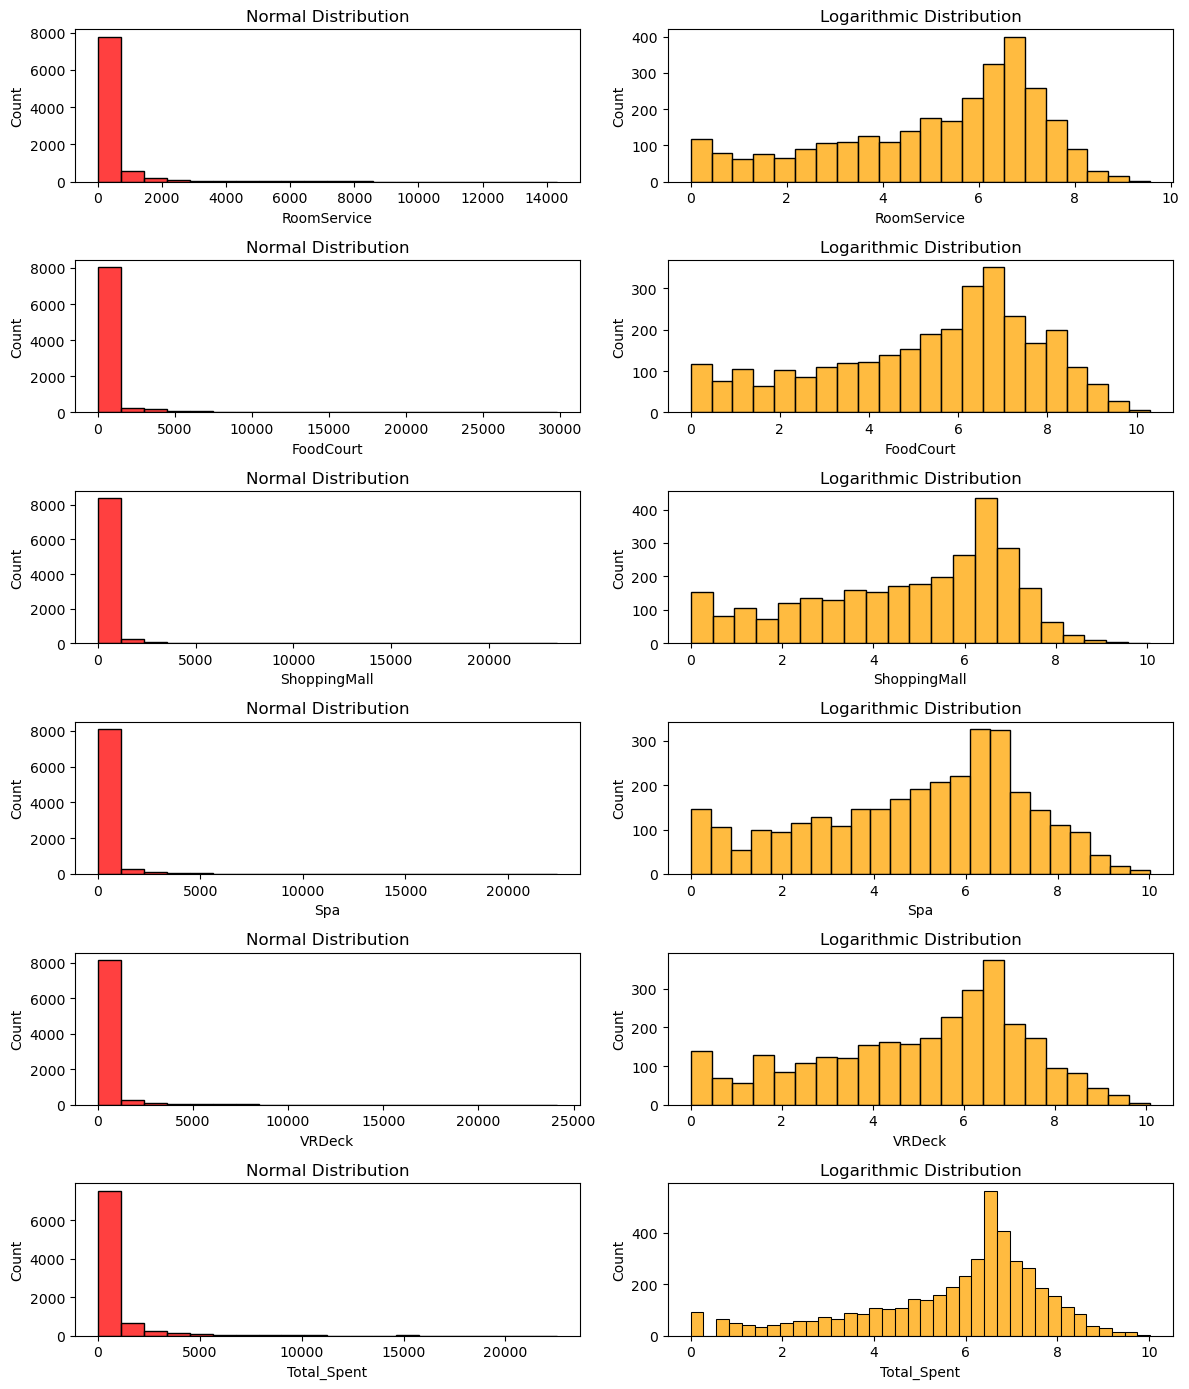

In [48]:
amenities.append('Total_Spent')

fig, axes = plt.subplots(len(amenities),2, figsize=(12,14))
for i, col in enumerate(amenities):
    sns.histplot(data=train_cleaning, x=col, ax=axes[i, 0], bins=20, color="red")
    sns.histplot(data=np.log(train_cleaning[[col]]), x=col, ax=axes[i, 1], color="orange")
    axes[i, 0].set_title('Normal Distribution')
    axes[i, 1].set_title('Logarithmic Distribution')
plt.tight_layout()

In [40]:
# For amenities that have 0, instead of log 0, we replace with 0.367

for col in amenities:
    train_cleaning.loc[train_cleaning[col]==0, col] = 0.367
    train_cleaning[col] = np.log(train_cleaning[col])
    test_cleaning.loc[test_cleaning[col]==0, col] = 0.367
    test_cleaning[col] = np.log(test_cleaning[col])

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_Spent,Cabin_deck,Cabin_num,Cabin_side,groupId,subId,Group_size,Name_first,Name_last
0,0001_01,Europa,0,TRAPPIST-1e,39.0,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,B,0,P,0001,01,1,Maham,Ofracculy
1,0002_01,Earth,0,TRAPPIST-1e,24.0,0,4.691348,2.197225,3.218876,6.308098,3.784190,6.489205,F,0,S,0002,01,1,Juanna,Vines
2,0003_01,Europa,0,TRAPPIST-1e,58.0,1,3.761200,8.182000,-1.002393,8.812099,3.891820,8.818482,A,0,S,0003,01,2,Altark,Susent
3,0003_02,Europa,0,TRAPPIST-1e,33.0,0,-1.002393,7.156956,5.916202,8.110427,5.262690,8.110427,A,0,S,0003,02,2,Solam,Susent
4,0004_01,Earth,0,TRAPPIST-1e,16.0,0,5.713733,4.248495,5.017280,6.336826,0.693147,6.766192,F,1,S,0004,01,1,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0,55 Cancri e,41.0,1,-1.002393,8.827468,-1.002393,7.404279,4.304065,7.404279,A,98,P,9276,01,1,Gravior,Noxnuther
8689,9278_01,Earth,1,PSO J318.5-22,18.0,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,G,1499,S,9278,01,1,Kurta,Mondalley
8690,9279_01,Earth,0,TRAPPIST-1e,26.0,0,-1.002393,-1.002393,7.534763,0.000000,-1.002393,0.000000,G,1500,S,9279,01,1,Fayey,Connon
8691,9280_01,Europa,0,55 Cancri e,32.0,0,-1.002393,6.955593,-1.002393,5.866468,8.081784,5.866468,E,608,S,9280,01,2,Celeon,Hontichre


In [50]:
test_train_cleaned=pd.concat([train_cleaning,test_cleaning],axis=0, keys=['train','test'])

In [51]:
test_train_cleaned.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Total_Spent', 'Cabin_deck', 'Cabin_num', 'Cabin_side', 'groupId',
       'subId', 'Group_size', 'Name_first', 'Name_last'],
      dtype='object')

In [52]:
to_drop = ['PassengerId','groupId']

test_train_cleaned.drop(columns=to_drop, inplace=True)

In [53]:
test_train_cleaned

HomePlanet CryoSleep    Destination        Age    VIP  RoomService  \
train 0        Europa         0    TRAPPIST-1e  39.000000      0    -1.002393   
      1         Earth         0    TRAPPIST-1e  24.000000      0     4.691348   
      2        Europa         0    TRAPPIST-1e  58.000000      1     3.761200   
      3        Europa         0    TRAPPIST-1e  33.000000      0    -1.002393   
      4         Earth         0    TRAPPIST-1e  16.000000      0     5.713733   
...               ...       ...            ...        ...    ...          ...   
test  4272      Earth      True    TRAPPIST-1e  34.000000  False    -1.002393   
      4273      Earth     False    TRAPPIST-1e  42.000000  False    -1.002393   
      4274       Mars      True    55 Cancri e  31.655941  False    -1.002393   
      4275     Europa     False    TRAPPIST-1e  17.759031  False    -1.002393   
      4276      Earth      True  PSO J318.5-22  43.000000  False    -1.002393   

            FoodCourt  ShoppingMall       Spa    VRDeck  Total_Spent  \
train 0     -1.002393     -1.002393 -1.002393 -1.002393    -1.002393   
      1      2.197225      3.218876  6.308098  3.784190     6.489205   
      2      8.182000     -1.002393  8.812099  3.891820     8.818482   
      3      7.156956      5.916202  8.110427  5.262690     8.110427   
      4      4.248495      5.017280  6.336826  0.693147     6.766192   
...               ...           ...       ...       ...          ...   
test  4272  -1.002393     -1.002393 -1.002393 -1.002393    -1.002393   
      4273   6.741701      2.833213  2.302585  4.969813     2.302585   
      4274  -1.002393     -1.002393 -1.002393 -1.002393    -1.002393   
      4275   7.893572     -1.002393 -1.002393  6.259581    -1.002393   
      4276  -1.002393     -1.002393 -1.002393 -1.002393    -1.002393   

           Cabin_deck  Cabin_num Cabin_side subId Group_size Name_first  \
train 0             B          0          P    01          1      Maham   
      1             F          0          S    01          1     Juanna   
      2             A          0          S    01          2     Altark   
      3             A          0          S    02          2      Solam   
      4             F          1          S    01          1      Willy   
...               ...        ...        ...   ...        ...        ...   
test  4272          G       1496          S    02          2      Jeron   
      4273         -1         -1         -1    01          1      Matty   
      4274          D        296          P    01          1     Jayrin   
      4275          D        297          P    01          1    Kitakan   
      4276          G       1498          S    01          1     Lilace   

              Name_last  
train 0       Ofracculy  
      1           Vines  
      2          Susent  
      3          Susent  
      4     Santantines  
...                 ...  
test  4272        Peter  
      4273      Scheron  
      4274         Pore  
      4275       Conale  
      4276    Leonzaley  

[12970 rows x 18 columns]

In [54]:
# Label encoding for categoricals
for colname in test_train_cleaned.select_dtypes("object"):
    test_train_cleaned[colname], _ = test_train_cleaned[colname].factorize()

/tmp/ipykernel_32/1152300148.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test_train_cleaned[colname], _ = test_train_cleaned[colname].factorize()
/tmp/ipykernel_32/1152300148.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test_train_cleaned[colname], _ = test_train_cleaned[colname].factorize()
/tmp/ipykernel_32/1152300148.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test_train_cleaned[colname], _ = test_train_cleaned[colname].factorize()


In [55]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

discrete_features = test_train_cleaned.xs("train").dtypes == int
mi_scores = make_mi_scores(test_train_cleaned.xs("train"), target, discrete_features )
mi_scores[::3]  # show a few features with their MI scores

Name_first     0.881551
Total_Spent    0.144581
VRDeck         0.067913
FoodCourt      0.042792
HomePlanet     0.010096
Cabin_side     0.006185
Name: MI Scores, dtype: float64

## 4.1 Mutual Information

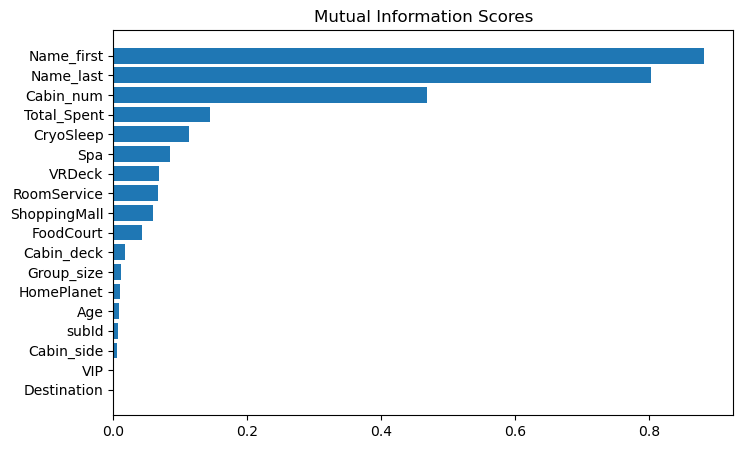

In [56]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [57]:
train_test = pd.get_dummies(test_train_cleaned)

print("These are our final list of features")
print(train_test.columns)

These are our final list of features
Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total_Spent',
       'Cabin_deck', 'Cabin_num', 'Cabin_side', 'subId', 'Group_size',
       'Name_first', 'Name_last'],
      dtype='object')


In [58]:
train_test.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total_Spent',
       'Cabin_deck', 'Cabin_num', 'Cabin_side', 'subId', 'Group_size',
       'Name_first', 'Name_last'],
      dtype='object')

In [59]:
train_test.columns = train_test.columns.str.replace('[#,@,&,(,),\[,\],]', '')

/tmp/ipykernel_32/2221879109.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_test.columns = train_test.columns.str.replace('[#,@,&,(,),\[,\],]', '')


In [60]:
train_test.head()

HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  \
train 0           0          0            0  39.0    0    -1.002393   
      1           1          0            0  24.0    0     4.691348   
      2           0          0            0  58.0    1     3.761200   
      3           0          0            0  33.0    0    -1.002393   
      4           1          0            0  16.0    0     5.713733   

         FoodCourt  ShoppingMall       Spa    VRDeck  Total_Spent  Cabin_deck  \
train 0  -1.002393     -1.002393 -1.002393 -1.002393    -1.002393           0   
      1   2.197225      3.218876  6.308098  3.784190     6.489205           1   
      2   8.182000     -1.002393  8.812099  3.891820     8.818482           2   
      3   7.156956      5.916202  8.110427  5.262690     8.110427           2   
      4   4.248495      5.017280  6.336826  0.693147     6.766192           1   

         Cabin_num  Cabin_side  subId  Group_size  Name_first  Name_last  
train 0          0           0      0           0           0          0  
      1          0           1      0           0           1          1  
      2          0           1      0           1           2          2  
      3          0           1      1           1           3          2  
      4          1           1      0           0           4          3

In [23]:
X_train_full, X_test = train_test.xs('train'), train_test.xs('test')
y_train_full=target.copy()

In [34]:
y_valid.shape

(1739,)

# 5. Model Building

## 5.1 Baseline Validation

In [24]:
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, jaccard_score, confusion_matrix, f1_score, recall_score, precision_score

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                    test_size=0.2, random_state=0)

y_train=y_train.astype(int)

In [37]:
model_table = pd.DataFrame()
def model_accuracy(i,model,model_name):
    score = cross_val_score(model,X_train, y_train, cv=5)
    model_table.loc[i,'Model Name']=model_name
    model_table.loc[i,'Score']= score.mean()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_train)
    y_hat = model.predict(X_valid)
    
    train_acc = accuracy_score(y_train,y_pred)*100
    model_table.loc[i,'Train Accuracy'] = train_acc
    test_acc = accuracy_score(y_valid,y_hat)*100
    model_table.loc[i,'Test Accuracy'] = test_acc
    model_table.loc[i,'Jaccard Score']=jaccard_score(y_valid, y_hat, pos_label=1)
    model_table.loc[i,'Recall Score']=recall_score(y_valid, y_hat)
    model_table.loc[i,'Recall Score']=f1_score(y_valid, y_hat)

In [39]:
lgb = LGBMClassifier()
cat = CatBoostClassifier(verbose=False)
lr = LogisticRegression(max_iter=2000)
rf = RandomForestClassifier(random_state=1)
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
xgb =  XGBClassifier(random_state=42)

estimators = [lgb,
             rf,
             lr,
             cat,
             dt,
             knn,
             xgb]

labels = ['LightGBM Classifier',
         'Random Forest',
         'Logistic Regression',
         'CAT Boost',
         'Decision Tree',
         'KNN',
         'XGB']

for i in range(len(estimators)):
    model_accuracy(i, estimators[i], labels[i])
    
display(model_table.sort_values(by='Score', ascending=False).style.background_gradient(cmap='summer_r'))


print("Baseline Validation done!")

,Model Name,Score,Train Accuracy,Test Accuracy,Jaccard Score,Recall Score
3,CAT Boost,0.804573,88.970377,81.023577,0.685115,0.813137
0,LightGBM Classifier,0.801265,91.328732,80.046003,0.668577,0.801374
1,Random Forest,0.794651,100.000000,80.276021,0.670509,0.802760
6,XGB,0.792781,96.663791,78.665900,0.648341,0.786659
2,Logistic Regression,0.764597,76.847857,76.998275,0.635369,0.777035
4,Decision Tree,0.730225,100.000000,73.720529,0.585675,0.738708
5,KNN,0.535520,70.793788,53.709028,0.374028,0.544426


Baseline Validation done!


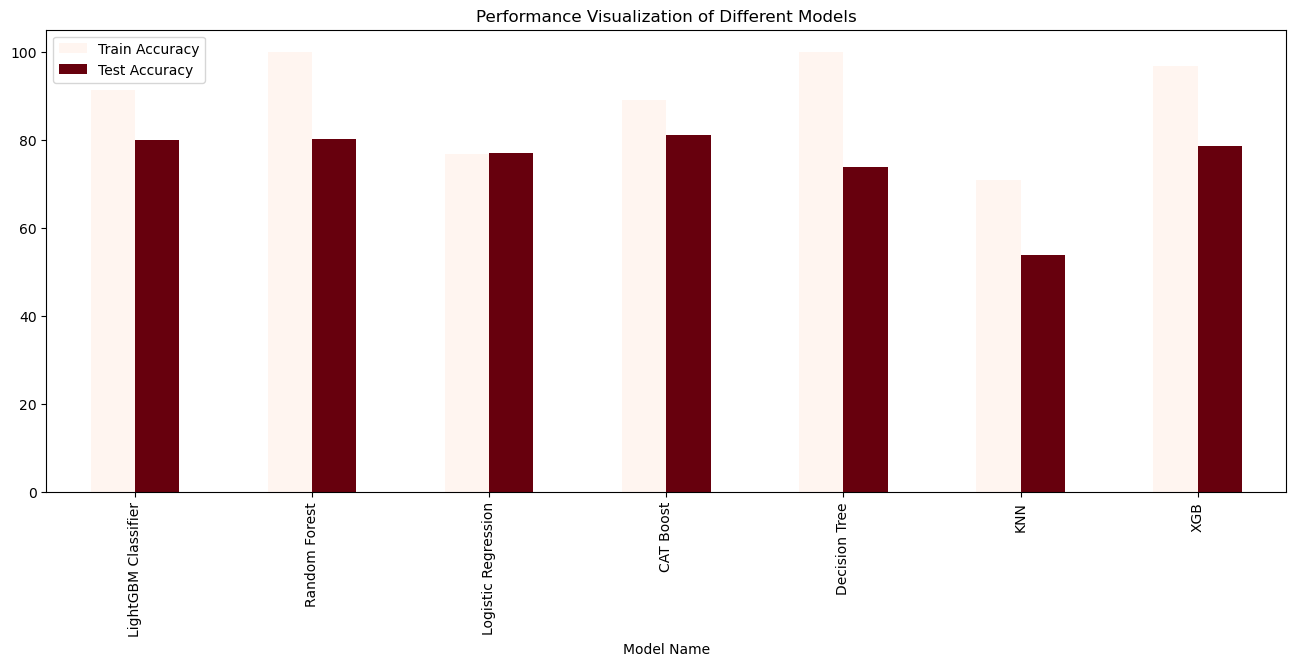

In [2]:
#Performance Plotting of Different Algorithms

model_table.plot(x='Model Name',y=["Train Accuracy","Test Accuracy"], figsize=(16,6),kind="bar",
        title="Performance Visualization of Different Models",cmap="Reds")
plt.show()

## 5.1 Parameter Tuning

In [65]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# def scorer(y, y_pred):
#     return mean_absolute_error(np.expm1(y_pred), np.expm1(y))
def get_best_parameters(model, parameters, cv, search_mode):
    if (search_mode == 'grid'):
        grid = GridSearchCV(model, 
                            parameters,
                            cv = cv, 
                            scoring = 'neg_root_mean_squared_error',
                            n_jobs = -1)
   
    elif (search_mode == 'randomized'):
        grid = RandomizedSearchCV(model,
                                  param_distributions = parameters,
                                  n_iter = 100,
                                  cv = cv, 
                                  scoring = 'neg_root_mean_squared_error',
                                  n_jobs = -1)
    
    grid.fit(X_train, y_train)
    return str(grid.best_params_)

In [66]:
lgbm_params = {
    'max_depth' : [2,3,4],
    'n_estimators': [100,200,500,600,700],
    'learning_rate': [0.001,0.01,0.05,0.1,0.5],
    'num_leaves':[16,17,18],
    'random_state':[0,42,48,50]
}

rf_params = {
   'n_estimators': [10,100,150],
   'max_features': [2,3,4],
   'max_depth': [2,5,10],
   'min_samples_split': [2,5,10],
   'min_samples_leaf': [2,5,10],
   'bootstrap': [False],
   'criterion': ['gini']
}

lr_params = {
    
    'penalty': ['l1', 'l2'],
    'max_iter': [1000,2000,5000],
    'penalty' : ['l1','l2','elasticnet'],
    'C' : np.logspace(-4,4,20),
    'solver' : ['liblinear','newton-cg','newton-cholesky']
}

cat_params = {
    'learning_rate': [0.018049356549743555],
     'depth': [3,5,6,8],
     'l2_leaf_reg': [5,7.838880563296214,9],
     'border_count': [160,182, 190],
     'verbose' : [False]
}

In [67]:
lgb = LGBMClassifier()
rf = RandomForestClassifier(random_state=1)
lr = LogisticRegression(max_iter=2000)
cat = CatBoostClassifier(verbose=False)

estimators = [lgb,
             rf,
             lr]

labels = ['LightGBM Classifier',
         'Random Forest',
         'Logistic Regression']

estimators_params = [lgbm_params,
                    rf_params,
                    lr_params]

In [68]:
import warnings
warnings.filterwarnings("ignore")

best_parameters = pd.DataFrame(columns = ['Model name', 'Best parameters'])

for i in range(len(estimators)):
    best_parameters.loc[i, 'Model name'] = labels[i]
    if (labels[i] in ['XGBoost', 'SVC']):
        best_parameters.loc[i, 'Best parameters'] = get_best_parameters(estimators[i], 
                                                                    estimators_params[i], 
                                                                    cv = 5, 
                                                                    search_mode = 'randomized')
    else:
        best_parameters.loc[i, 'Best parameters'] = get_best_parameters(estimators[i], 
                                                                    estimators_params[i], 
                                                                    cv = 5, 
                                                                    search_mode = 'grid')


In [69]:
display(best_parameters.style.background_gradient(cmap='summer_r'))

,Model name,Best parameters
0,LightGBM Classifier,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}"
1,Random Forest,"{'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}"
2,Logistic Regression,"{'C': 0.08858667904100823, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}"


In [ ]:
import optuna
from sklearn import datasets
def objective(trial):
    max_depth = trial.suggest_int('max_depth',1,5)
    n_estimators = trial.suggest_int('n_estimators',100,650)
    learning_rate =trial.suggest_int('learning_rate',0.001,0.5)
    num_leaves = trial.suggest_int('num_leaves',10,20)
    clf = LGBMClassifier(random_state=42, max_depth=max_depth, n_estimators= n_estimators,learning_rate=learning_rate,num_leaves=num_leaves)
    return sklearn.model_selection.cross_val_score(clf,X_train,y_train,n_jobs=-1,cv=5).mean()
    

In [70]:
print("Model Tuning Complete!")

Model Tuning Complete!


## 6.2 Model Evaluations

In [71]:
from sklearn.model_selection import cross_validate

def test_estimators(X, y, estimators, labels, cv):
    ''' 
    A function for testing multiple estimators.
    It takes: full train data and target, list of estimators, 
              list of labels or names of estimators,
              cross validation splitting strategy;
    And it returns: a DataFrame of table with results of tests
    '''
    result_table = pd.DataFrame()

    row_index = 0
    for est, label in zip(estimators, labels):
        est_name = label
        result_table.loc[row_index, 'Model Name'] = est_name
        cv_results = cross_validate(est,
                                    X,
                                    y,
                                    cv = cv,
                                    scoring = 'neg_root_mean_squared_error',
                                    n_jobs = -1)
        
        result_table.loc[row_index, 'Test RMSE'] = -cv_results['test_score'].mean()
        result_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        result_table.loc[row_index, 'Fit Time'] = cv_results['fit_time'].mean()

        row_index += 1

    result_table.sort_values(by=['Test RMSE'], ascending = True, inplace = True)

    return result_table


In [72]:
from ast import literal_eval

lgb = LGBMClassifier(**literal_eval(best_parameters.loc[0, 'Best parameters']))
rf = RandomForestClassifier(**literal_eval(best_parameters.loc[1, 'Best parameters']))
lr = LogisticRegression(**literal_eval(best_parameters.loc[2, 'Best parameters']))
xgb = XGBClassifier('binary:logistic',colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=10, 
                             min_child_weight=1.7817, n_estimators=1500,
                             reg_alpha=4.5, reg_lambda=8.5,
                             subsample=0.5213,
                             random_state=42)
cat = CatBoostClassifier(learning_rate= 0.018049356549743555,depth= 8,
                         l2_leaf_reg= 7.838880563296214,
                         border_count= 160,
                         verbose= False)

estimators = [lgb,
             rf,
             lr,
             xgb,
             cat]

labels = ['LightGBM Classifier',
         'Random Forest',
         'Logistic Regression',
         'XGB',
         'CAT Boost Classifier']

results = test_estimators(X_train, y_train, estimators, labels, cv = 5)
results.style.background_gradient(cmap = 'Reds')

,Model Name,Test RMSE,Test Std,Fit Time
4,CAT Boost Classifier,0.439106,0.006450,4.873265
0,LightGBM Classifier,0.442958,0.005104,0.472282
3,XGB,0.443870,0.005482,12.314127
1,Random Forest,0.444913,0.007027,1.182190
2,Logistic Regression,0.480268,0.009513,0.146466


In [73]:
print("Model Evaluation Done!")

Model Evaluation Done!


In [74]:
#We run the final fitting with full training data!

from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lgb',lgb),('rf',rf),('lr',lr),('xgb',xgb),('cat',cat)], voting="soft")

voted = voting_clf.fit(X_train_full,y_train_full)

In [75]:
print("Voting Classifier Completed!")

Voting Classifier Completed!


In [77]:
preds = voted.predict(X_test)

In [78]:
basic_submission_val={'PassengerId':test.PassengerId,'Transported':preds.astype(bool)}
base_submssion = pd.DataFrame(data=basic_submission_val)
base_submssion.to_csv('submission.csv',index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!
